In [2]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
#%matplotlib widget
#%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from progressbar import ProgressBar

fg_path = './models/Batch Renderding/scene/image_out/*'
#label_path='./models/Batch Renderding/scene/label_out/*'
bg_path = '/run/media/d0048/DATA/data/imagenet_raw/val_nodir/*'

In [3]:
fg_seg_pairs=[]
def crop_zero(image,reference=None):
    if(reference is None):
        reference=image
    nonzeros = cv2.findNonZero(reference[:,:,-1])
    upper = np.squeeze(np.max(nonzeros, axis=0).astype(int))
    lower = np.squeeze(np.min(nonzeros, axis=0).astype(int))
    return image[lower[1]:upper[1],lower[0]:upper[0]]

early=10
pbar = ProgressBar()
for name in pbar(glob.glob(fg_path)):
    if(early>0):early-=1
    if(early==0):break
    image = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    image[:, :, 0], image[:,:, 2] = image[:,:, 2], image[:, :,0].copy()
    label=cv2.imread(name.replace('image','label'),cv2.IMREAD_UNCHANGED)
    label=crop_zero(label,reference=image)
    if(np.sum(label)==0):continue
    #label=np.sum(label,axis=2)
    #label[label>0]=1
    image=crop_zero(image)
    fg_seg_pairs+=[[image,label]]
    '''
    plt.figure()
    plt.imshow(image)
    plt.imshow(label)
    break
    '''
print('{} pairs of foreground loaded.'.format(fg_seg_pairs.__len__()))

9 pairs of foreground loaded.


## Augmentation

### Augmentor

In [ ]:
import Augmentor
p = Augmentor.Pipeline(fg_path.replace('*',''))
p.ground_truth(fg_path.replace('*','').replace('image','label'))
p.rotate(probability = 1, max_left_rotation =5, max_right_rotation =5)
p.flip_left_right(probability = 0.5)
p.flip_top_bottom(probability = 0.3)
p.sample(10)

In [ ]:
batch_size = 6
g = p.keras_generator(batch_size=batch_size)

X, y = next(g)
print(X.shape)
print(y.shape)

### ImgAug

(831, 724, 4)
(831, 724, 4)
(1, 831, 724, 4)
(1, 831, 724, 4)


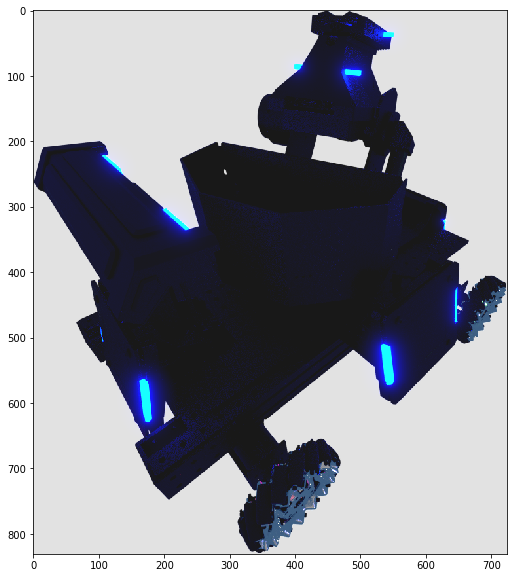

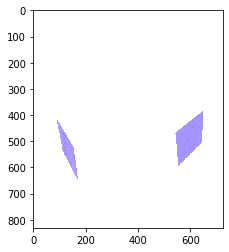

In [6]:
import imgaug as ia
import imgaug.augmenters as iaa
#from imgaug.augmentables.segmaps import SegmentationMapsOnImage

ia.seed(1)

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.SomeOf((0, 5),
            [
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, .2),
                        n_segments=(40, 400)
                    )
                ),
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.8, 1.5), per_channel=0.5),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
            ],
            random_order=True
        )
    ],
    random_order=True
)

def augment_pair(fg,label):
    fg=np.expand_dims(fg, axis=0)#[:,:,:,0:3]
    label=np.expand_dims(label, axis=0)
    print(fg.shape)
    print(label.shape)
    label_i, segmaps_aug_i = seq(images=fg, segmentation_maps=label)
    #ret = seq(images=fg, segmentation_maps=label)
    return label_i,segmaps_aug_i

idx=np.random.randint(0,fg_seg_pairs.__len__())
fg_pair=fg_seg_pairs[idx]
print(fg_pair[0].shape)
print(fg_pair[1].shape)
fg_pair=augment_pair(*fg_pair)


plt.figure(figsize=[10,10])
plt.imshow(fg_pair[0].squeeze())
plt.figure()
plt.imshow(fg_pair[1].squeeze())

## Synthesis

(1, 960, 1080, 3)
(1, 960, 1080, 4)
Agumented
{'size': array([0.33369088, 0.25315918, 0.2840523 , 0.18008864, 0.37497784,
       0.25102254, 0.3629031 , 0.20470128, 0.1939323 , 0.4209033 ,
       0.55765821, 0.44708538, 0.41416821, 0.50806475, 0.33315052,
       0.5928633 , 0.16087244, 0.27319245, 0.54862938, 0.25312252]), 'min_num': 1.8827551402751141, 'min_area': 0.0012435032738552841}
(1, 960, 1080, 3)
(1, 960, 1080, 4)
Agumented
{'size': array([0.57924097, 0.43497391, 0.37202937, 0.24692564, 0.48138311,
       0.17204722, 0.52253705, 0.38677698, 0.28825569, 0.40561065,
       0.18778972, 0.24106934, 0.43253232, 0.26626785, 0.44325541,
       0.17930331, 0.56201861, 0.15475119, 0.51050271, 0.41865307]), 'min_num': 1.1037544535150907, 'min_area': 0.001020937879703904}
(1, 960, 1080, 3)
(1, 960, 1080, 4)
Agumented
{'size': array([0.59237696, 0.46435237, 0.29180877, 0.46684233, 0.57186231,
       0.36773105, 0.36763018, 0.22292824, 0.25404505, 0.32322156,
       0.29504249, 0.54950018,

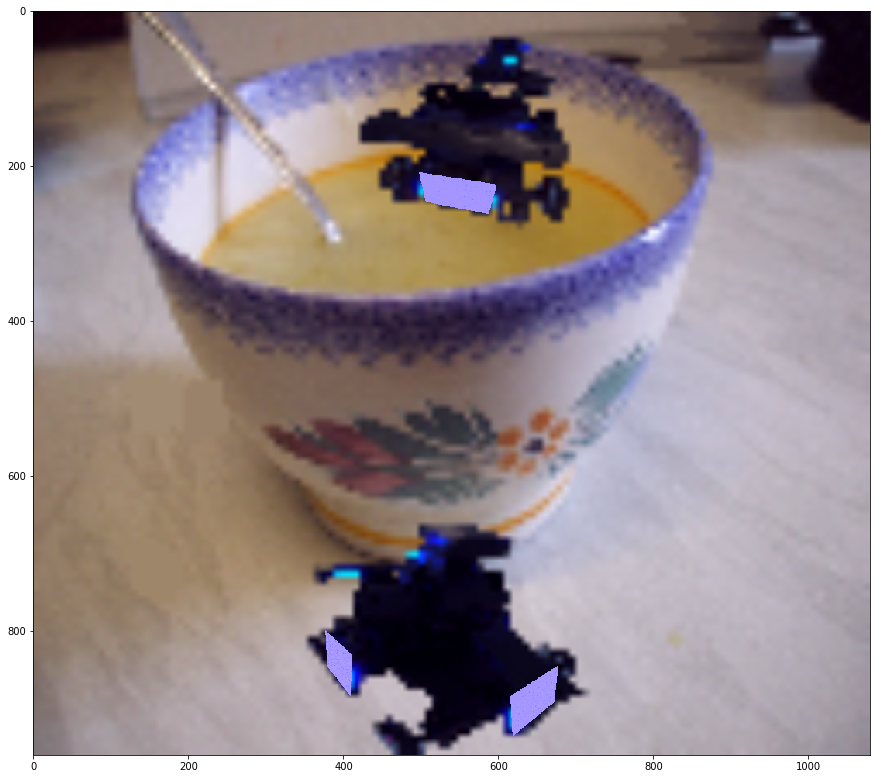

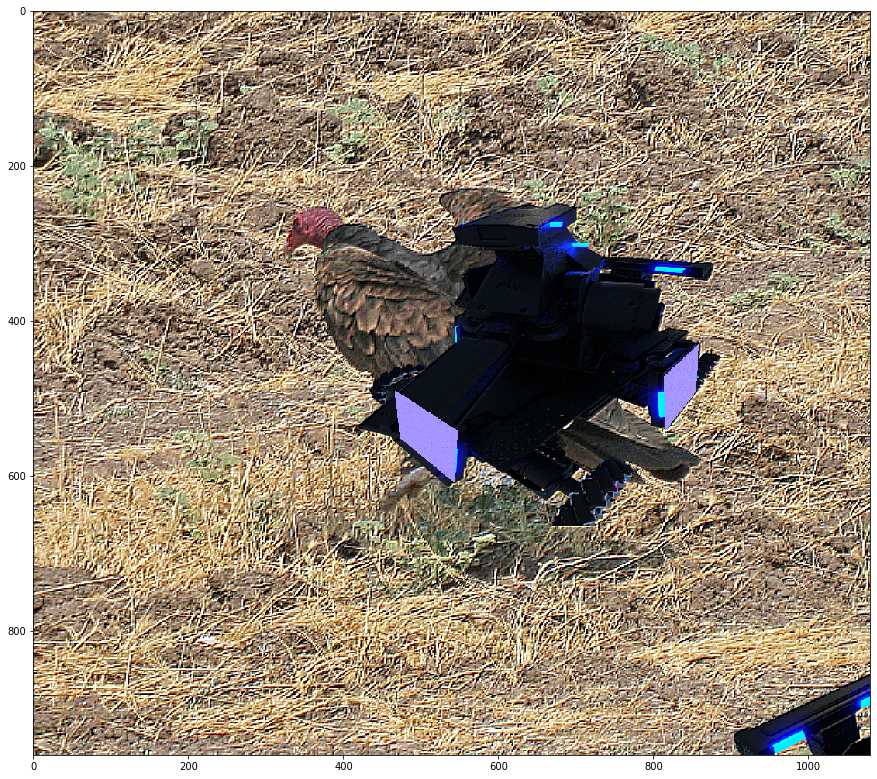

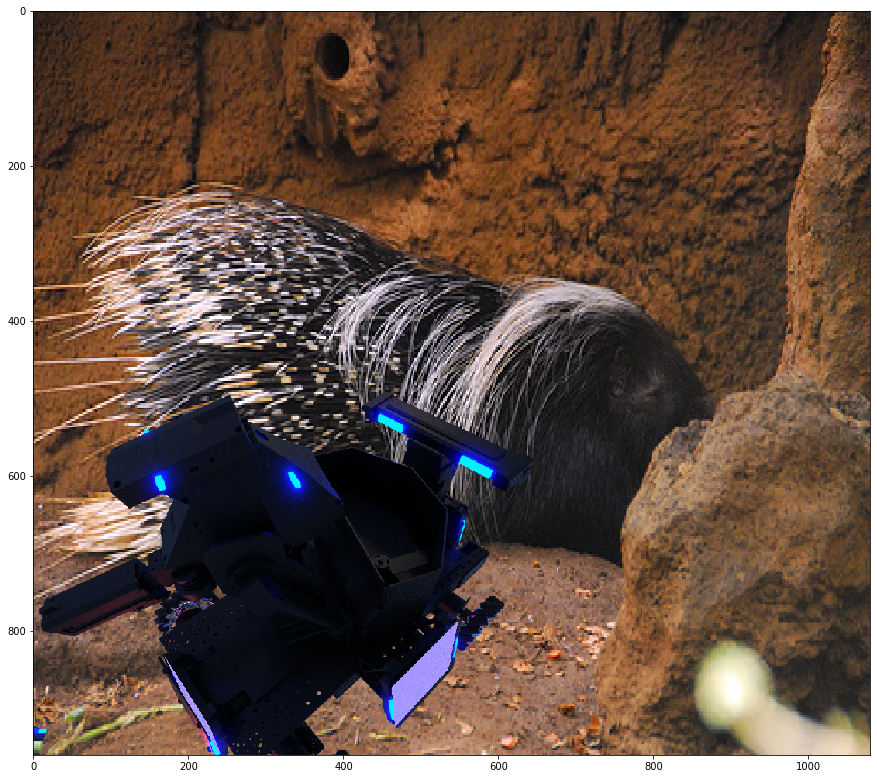

In [13]:
res = [1080, 960]
# size ratio range, numbers, blur, shear, explosure
para_space_range = {'size': [0.15, 0.6], 'min_num': [1, 2],'min_area':[0.001,0.002]}


def get_para():
    para = para_space_range.copy()
    para['min_num'] = np.random.uniform(low=para_space_range['min_num'][0], high=para_space_range['min_num'][1])
    para['size'] = np.random.uniform(low=para_space_range['size'][0], high=para_space_range['size'][1],
                                     size=int(para['min_num'])*20)
    para['min_area']=np.random.uniform(low=para_space_range['min_area'][0], high=para_space_range['min_area'][1])
    return para
def get_pair_PIL():
    idx = np.random.randint(0, fg_seg_pairs.__len__())
    fg_pair = fg_seg_pairs[idx]
    fg=fg_pair[0].copy()
    #fg[:,:,0:2]=0
    #fg[:,:,3][fg[:,:,2]<140]=0
    fg = Image.fromarray(fg, 'RGBA')
    label = Image.fromarray(fg_pair[1], 'RGBA')
    return fg, label
def get_bg_pair():
    files=glob.glob(bg_path)
    idx = np.random.randint(0, bg_path.__len__())
    bg = Image.open(files[idx])
    bg = bg.resize(res)
    bg_label=Image.new('RGBA', bg.size, (0, 0, 0, 0))
    return bg,bg_label
def area_percent(img):
    img_full=img.copy()
    img_full[:]=255
    return np.sum(img)/np.sum(img_full)

#pbar = ProgressBar()
#for bg in pbar(glob.glob(bg_path)):
def get_blended(plot=True,augment=True):
    bg,bg_label=get_bg_pair()
    para = get_para()

    n=0
    while area_percent(np.array(bg_label))<para['min_area'] or n<=np.min(para['min_num']):
    #for n in range(int(para['min_num'])):
        fg, label = get_pair_PIL()
        newsize=(np.array(res)*para['size'][n%int(para['size'].shape[0])]).astype(np.int)
        fg = fg.resize(newsize)
        label = label.resize(newsize)
        
        loc = (np.random.randint(0, res[0]), np.random.randint(0, res[1]))
        bg.paste(fg, loc, fg)
        bg_label.paste(label,loc,label)
        n+=1

    #Augmentation
    if augment:
        bg,bg_label=augment_pair(np.array(bg),np.array(bg_label))
        bg,bg_label=bg.squeeze(),bg_label.squeeze()
        print('Agumented')
    if plot:
        print(para)
        plt.figure(figsize=(15, 15))
        plt.imshow(bg)
        plt.imshow(bg_label)
    return bg,bg_label
get_blended()
get_blended()
get_blended()

print('done')

## Segmentation

In [11]:
batch_size=1
import torch
import torch.nn as nn
import torch.nn.functional as F
def downconv(in_channels, out_channels, kernel_size):
    padding = int(kernel_size / 2)
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                  kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
    )
def downsamp(channels):
    return nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(channels)
    )
def up(in_channels, out_channels, kernel_size):
    padding = int(kernel_size / 2)
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                  kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.Upsample(scale_factor=2)
    )
# %%
class Model(nn.Module):
    def __init__(self, in_channels=3, channels=128, kernel_size=3, dropout=0.5):
        super(Model, self).__init__()
        self.dropout = dropout
        self.downconv1 = downconv(in_channels, channels, kernel_size)
        self.downsamp1 = downsamp(channels)
        self.downconv2 = downconv(channels, 2 * channels, kernel_size)
        self.downsamp2 = downsamp(2 * channels)
        self.downconv3 = downconv(2 * channels, 4 * channels, kernel_size)
        self.downsamp3 = downsamp(4 * channels)
        self.up1 = up(4 * channels, 4 * channels, kernel_size)
        self.up2 = up(8 * channels, 2 * channels, kernel_size)
        self.up3 = up(4 * channels, channels, kernel_size)
        padding = int(kernel_size / 2)
        self.last = nn.Sequential(
            nn.Conv2d(in_channels=2 * channels, out_channels=channels,
                      kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels, out_channels=channels,
                      kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=1)#,
            #nn.Sigmoid()
        )

    def forward(self, x):
        d1 = self.downconv1(x)
        ds1 = self.downsamp1(d1)
        d2 = self.downconv2(ds1)
        ds2 = self.downsamp2(d2)
        d3 = self.downconv3(ds2)
        ds3 = self.downsamp3(d3)
        u = self.up1(ds3)
        u = torch.cat((d3, u), dim=1)
        u = nn.Dropout2d(self.dropout)(u)
        u = self.up2(u)
        u = torch.cat((d2, u), dim=1)
        u = nn.Dropout2d(self.dropout)(u)
        u = self.up3(u)
        u = torch.cat((d1, u), dim=1)
        u = nn.Dropout2d(self.dropout)(u)
        u = self.last(u)
        u = u.reshape(-1, res[1], res[0])
        return u
#np.random.seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available
device='cpu'
model=Model().to(device)
#model = nn.DataParallel(model).to(device)
print(device)

# original saved file with DataParallel
state_dict = torch.load('./checkpoint/model.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)
#model.load_state_dict(torch.load('./checkpoint/model.pth'))

cpu


<All keys matched successfully>

## Training

In [ ]:
def load_train(queue):
    while True:
        img_batch=[]
        label_batch=[]
        try:
            while img_batch.__len__()<batch_size:
                img,label=get_blended(plot=False)
                img=np.array(img)[:,:,0:4]
                label=np.array(label)
                label=np.sum(label,axis=2)
                label[label!=0]=1
                img_batch.append(img.astype(np.float))
                label_batch.append(label.astype(np.float))
                
        except Exception as e:
                print(e)
                continue
        img_batch=np.array(img_batch).transpose([0,3,1,2])
        label_batch=np.array(label_batch).transpose([0,1,2])
        queue.put((img_batch,label_batch))
        print('load')
q_train = torch.multiprocessing.Queue(maxsize=100)
p1 = torch.multiprocessing.Process(target=load_train, args=(q_train,))
load_train(q_train)
#p1.start()

In [1]:
save_directory_name = './checkpoint'
sample_directory_name = './samples'

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
criterion = nn.BCEWithLogitsLoss().to(device)
for e in range(10000000):
    model.train()
    pair = q_train.get()
    img = torch.tensor(pair[0],dtype=torch.float, requires_grad = True,device=device)
    label = torch.tensor(pair[1],dtype=torch.float,device=device)
    optimizer.zero_grad()
    pred = model(img)

    loss = criterion(pred.reshape([batch_size,-1]), label.reshape([batch_size,-1]))
    loss.backward()
    optimizer.step()
    print(loss)
    
    if e%32 == 0:
        np.savez_compressed(sample_directory_name+'/sample', pred.cpu().data.numpy())
        np.savez_compressed(sample_directory_name+'/sample_img', img.cpu().data.numpy())
        torch.save(model.state_dict(), save_directory_name+'/model.pth')

NameError: name 'll' is not defined

## Inspect

(4, 960, 1080)
(4, 960, 1080)
(4, 960, 1080)


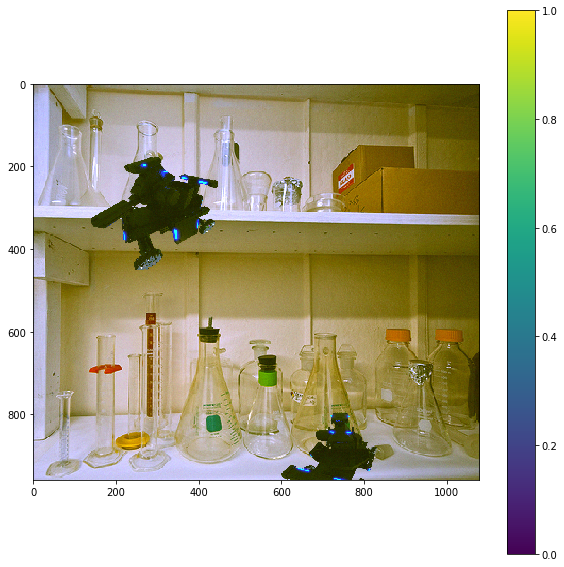

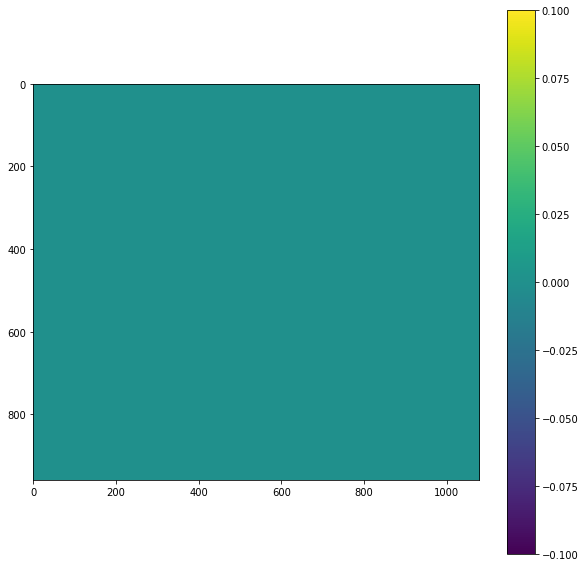

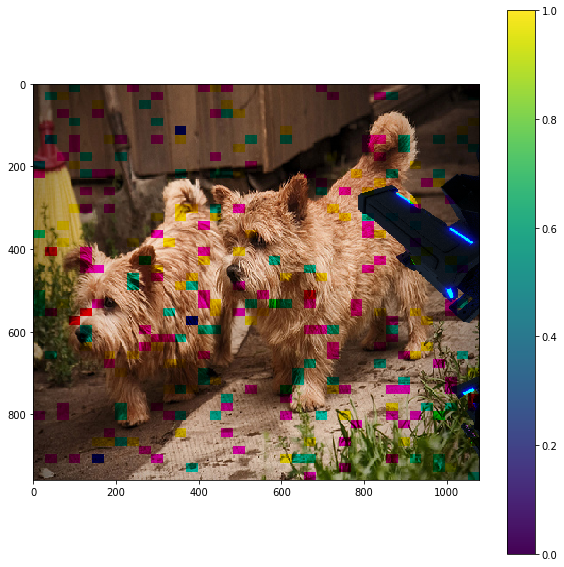

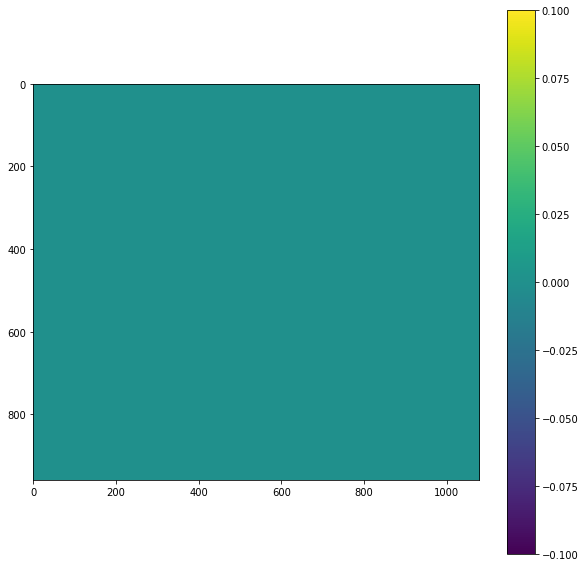

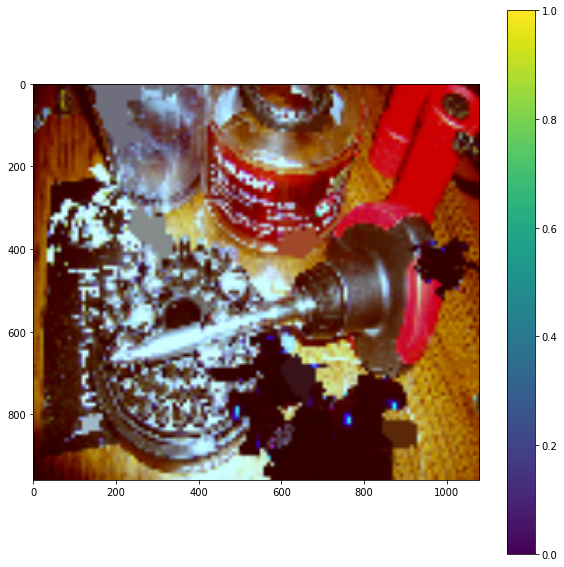

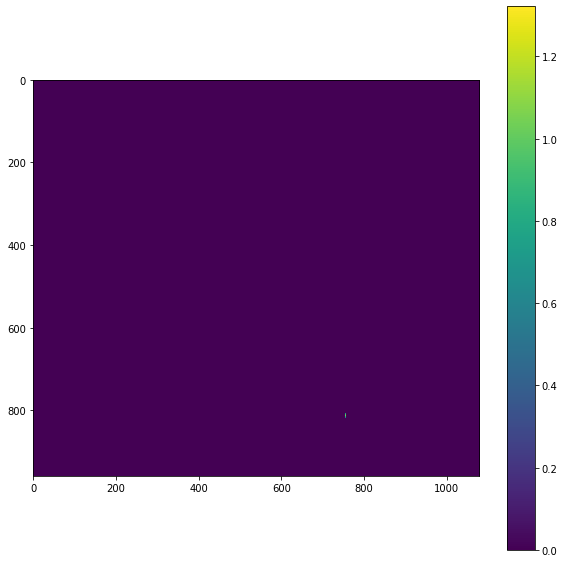

In [17]:
for idx in range(3):
    sample=np.load('./samples/sample.npz')['arr_0']
    sample_img=np.load('./samples/sample_img.npz')['arr_0'].transpose([0,2,3,1])
    sample_label=np.load('./samples/sample_label.npz')['arr_0']
    print(sample.shape)
    sample[sample<0.5]=0
    
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_img[idx]/255)
    plt.colorbar()

    plt.figure(figsize=(10, 10))
    plt.imshow(sample[idx])
    plt.colorbar()

    #plt.figure(figsize=(10, 10))
    #plt.imshow(sample_label[idx])
    #plt.colorbar()

Choosing from 6 files
torch.Size([1, 3, 960, 1080])
torch.Size([1, 3, 960, 1080])
torch.Size([1, 3, 960, 1080])
torch.Size([1, 3, 960, 1080])
torch.Size([1, 3, 960, 1080])
torch.Size([1, 3, 960, 1080])


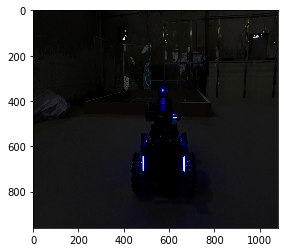

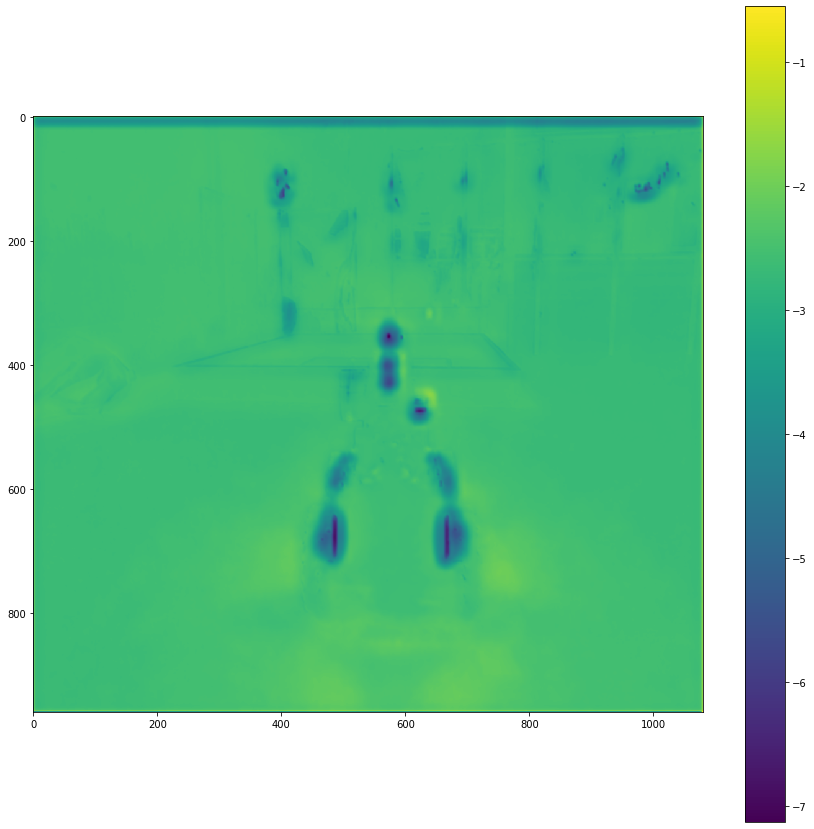

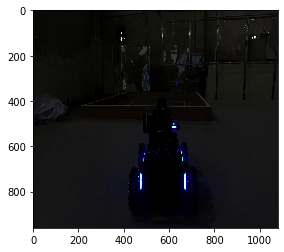

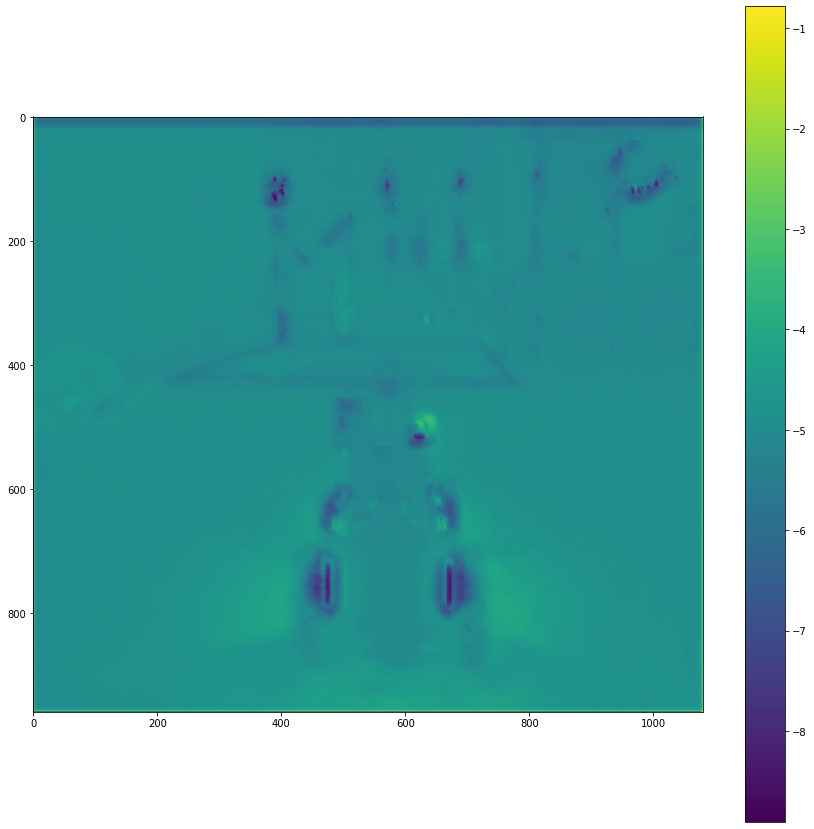

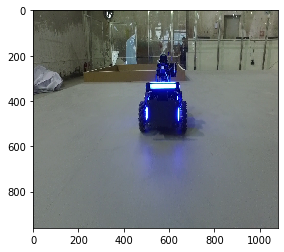

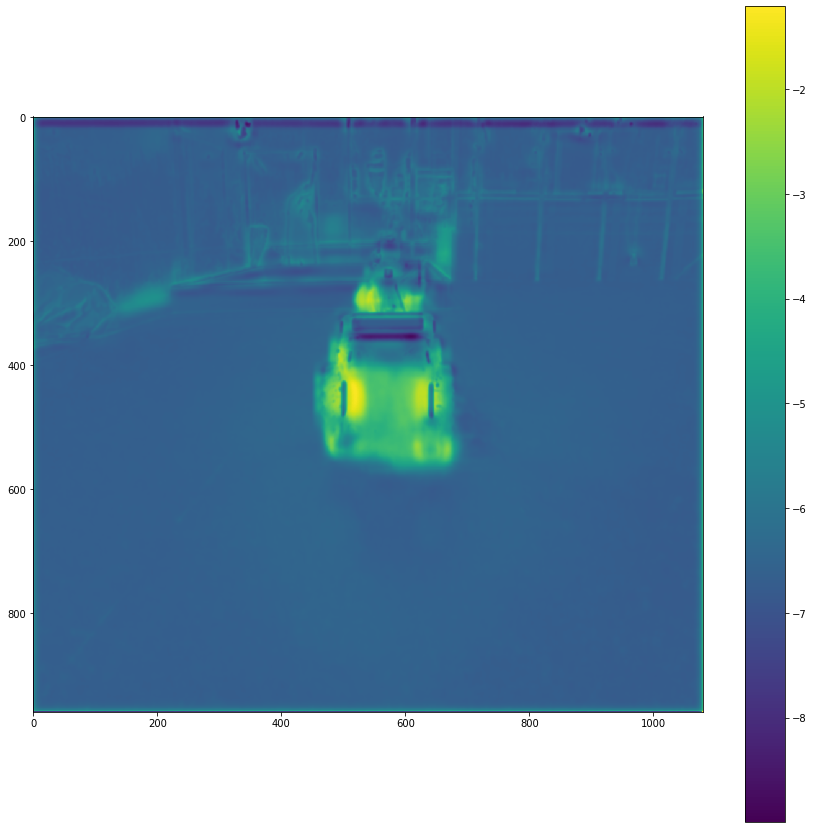

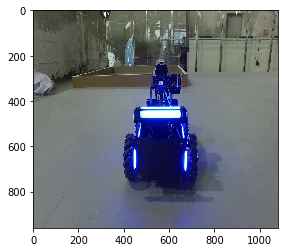

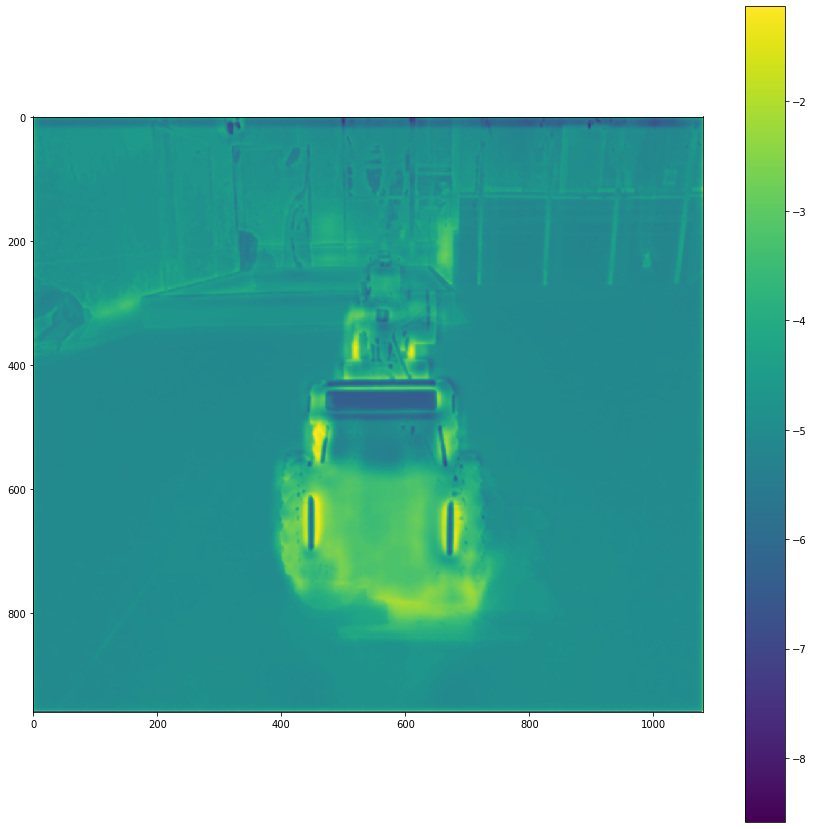

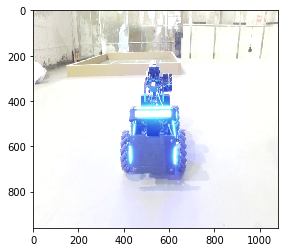

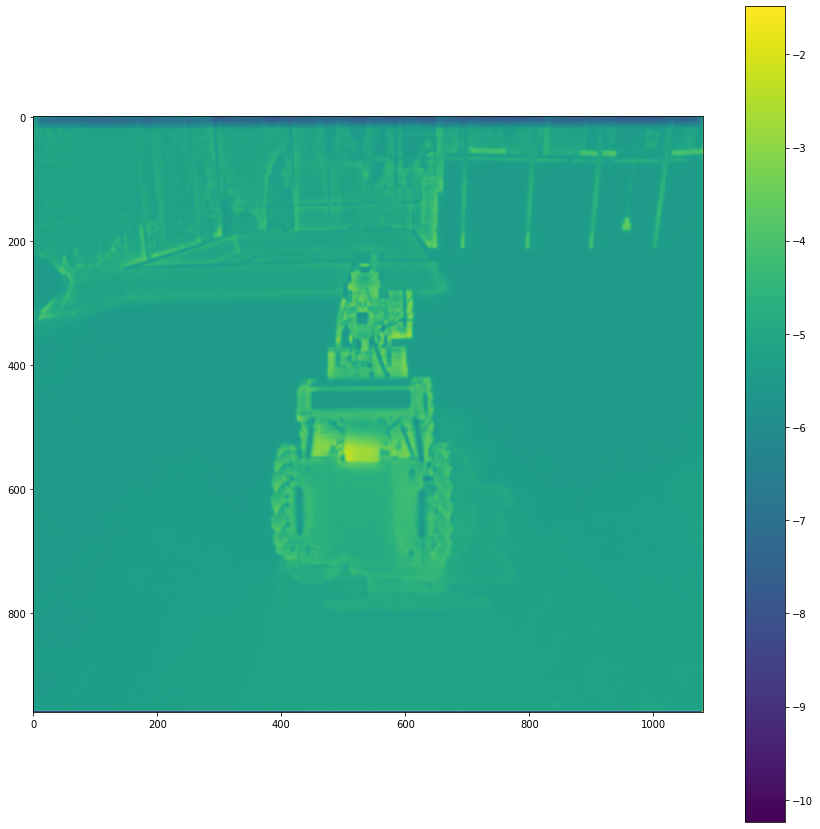

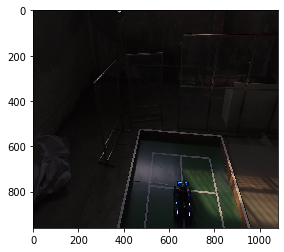

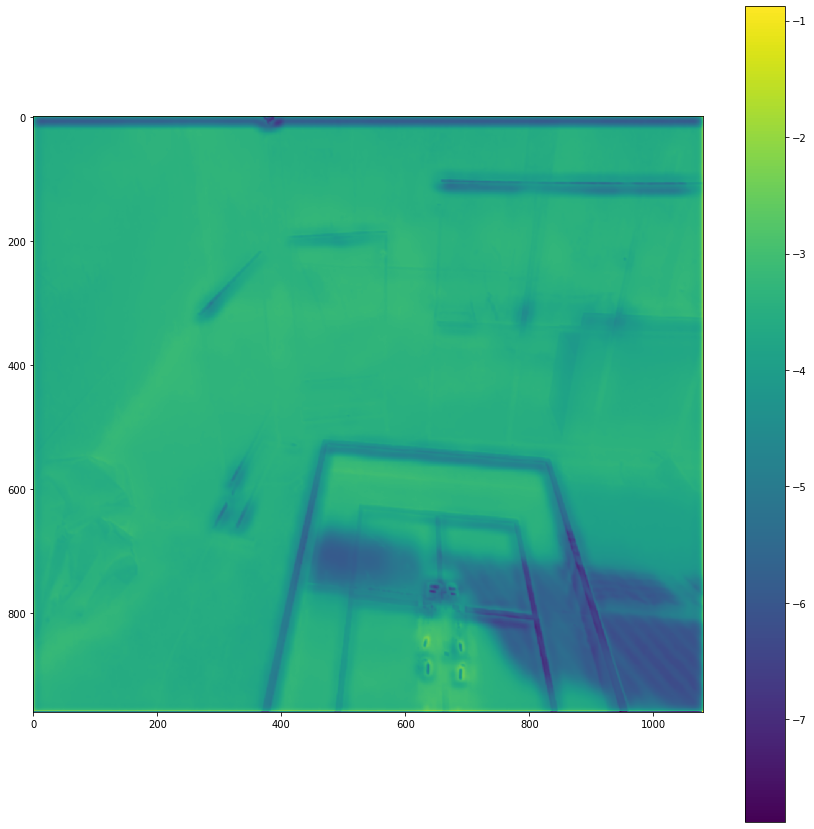

In [18]:
# original saved file with DataParallel
state_dict = torch.load('./checkpoint/model.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

def load_real_img(paths,plot=True):
    img_batch=[]
    for path in paths:
        bg = Image.open(path)
        bg = bg.resize(res)
        img=np.array(bg)[:,:,0:4]
        #img[:, :, 0], img[:,:, 2] = img[:,:, 2], img[:, :,0].copy()

        img_batch.append(img.astype(np.float))
        if plot:
            plt.figure()
            plt.imshow(img)
    img = torch.tensor(img_batch,dtype=torch.float,device=device).permute([0,3,1,2])
    return img

torch.cuda.empty_cache()
model.eval()

'''
img,label=get_blended()
img_batch=[]
label_batch=[]
img=np.array(img)[:,:,0:4]
label=np.array(label)
label=np.sum(label,axis=2)
label[label!=0]=1

label_batch.append(label.astype(np.float))
img_batch=np.array(img_batch).transpose([0,3,1,2])
label_batch=np.array(label_batch).transpose([0,1,2])

img = torch.tensor(img_batch,dtype=torch.float,device=device)
label = torch.tensor(label_batch,dtype=torch.float,device=device)
'''
files=glob.glob('/home/d0048/Program-code/IlliniRobomaster/RMSynthesis/raw/blue/*')
print('Choosing from {} files'.format(files.__len__()))
file=files[np.random.randint(0, files.__len__())]
for file in files:
    img=load_real_img([file])
    print(img.shape)
    out=model(img)

    del img
    torch.cuda.empty_cache()

    see=out.detach().cpu().numpy()
    plt.figure(figsize=[15,15])
    plt.imshow(see.squeeze())
    plt.colorbar()

13.708438


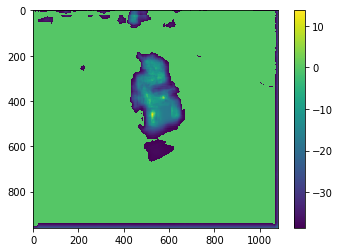

In [40]:
result=out.detach().cpu().numpy().copy().squeeze()
#result/=(np.max(result)-np.min(result))
print(np.max(result))
result[result<np.average(result)]=0
#result=np.rot90(result,k=2)
plt.figure()
plt.imshow(result)
plt.colorbar()